In [ ]:
# !pip install datasets

In [115]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ipywidgets import FloatProgress
from tqdm import tqdm

from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

from collections import Counter
from typing import List
from datasets import Dataset, DatasetDict
from datasets import load_dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import seaborn
import string
from nltk.tokenize import RegexpTokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [116]:
seaborn.set(palette='summer')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [117]:
train_df = pd.read_csv('train_spam.csv')
train_df['text_type'] = train_df['text_type'].map({'ham': 0, 'spam': 1})

train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [118]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_type', 'text', '__index_level_0__'],
        num_rows: 13022
    })
    test: Dataset({
        features: ['text_type', 'text', '__index_level_0__'],
        num_rows: 3256
    })
})

In [119]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 50

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 13022/13022 [00:03<00:00, 4085.27it/s]


Размер словаря: 1673


In [120]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "text_type": self.data[idx]['text_type']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['text_type'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'text_type': labels
    }

    return new_batch

In [121]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(69)
eval_dataset = WordDataset(dataset['test'])

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [122]:
def evaluate(model) -> float:
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['text_type'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    roc_auc = roc_auc_score(target.cpu(), predictions.cpu())

    return roc_auc

In [123]:
import torch
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max',
        num_layers=1, dropout=0.1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2 * hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, 2 * hidden_dim] (forward and backward directions)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, 2 * hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction


In [124]:
def visualize(losses, roc_aucs):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    axes[0].plot(np.arange(len(losses)), losses, color='blue')
    axes[0].set_title('Losses')
    axes[0].set_xlabel('Epoch')

    axes[1].plot(np.arange(len(roc_aucs)), roc_aucs, color='green')
    axes[1].set_title('ROC-AUC')
    axes[1].set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()

In [133]:
def train_df(model, optimizer, criterion, num_epoch):
    eval_steps = len(train_dataloader) // 2
    losses = []
    roc_aucs = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['text_type'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == eval_steps - 1:
                model.eval()
                roc_auc = evaluate(model)
                roc_aucs.append(roc_auc)
                model.train()
                print(f'Current ROC AUC: {round(roc_auc, 4)}')

        losses.append(sum(epoch_losses) / len(epoch_losses))


    return losses, roc_aucs

In [134]:
model = BiLSTM(hidden_dim=256, vocab_size=len(vocab), num_layers=2, dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [135]:
losses, roc_auc = train_df(model, optimizer, criterion, num_epoch=6)
print(f"\nThe best Loss: {min(losses)}, The best ROC AUC: {max(roc_auc)}")

Training epoch 0::  51%|█████     | 207/407 [00:11<00:36,  5.54it/s]

Current ROC AUC: 0.9245


Training epoch 0:: 100%|██████████| 407/407 [00:22<00:00, 17.95it/s]


Current ROC AUC: 0.9361


Training epoch 1::  51%|█████     | 207/407 [00:11<00:36,  5.49it/s]

Current ROC AUC: 0.8862


Training epoch 1:: 100%|██████████| 407/407 [00:22<00:00, 17.95it/s]


Current ROC AUC: 0.9198


Training epoch 2::  51%|█████     | 207/407 [00:12<00:44,  4.48it/s]

Current ROC AUC: 0.9493


Training epoch 2:: 100%|██████████| 407/407 [00:23<00:00, 17.63it/s]


Current ROC AUC: 0.9484


Training epoch 3::  51%|█████     | 206/407 [00:11<00:36,  5.50it/s]

Current ROC AUC: 0.945


Training epoch 3:: 100%|██████████| 407/407 [00:22<00:00, 18.15it/s]


Current ROC AUC: 0.9508


Training epoch 4::  51%|█████     | 206/407 [00:11<00:43,  4.67it/s]

Current ROC AUC: 0.9309


Training epoch 4:: 100%|██████████| 407/407 [00:22<00:00, 17.75it/s]


Current ROC AUC: 0.9363


Training epoch 5::  51%|█████     | 207/407 [00:11<00:46,  4.29it/s]

Current ROC AUC: 0.9461


Training epoch 5:: 100%|██████████| 407/407 [00:23<00:00, 17.42it/s]

Current ROC AUC: 0.948

The best Loss: 0.020165143376508047, The best ROC AUC: 0.9507691917783917


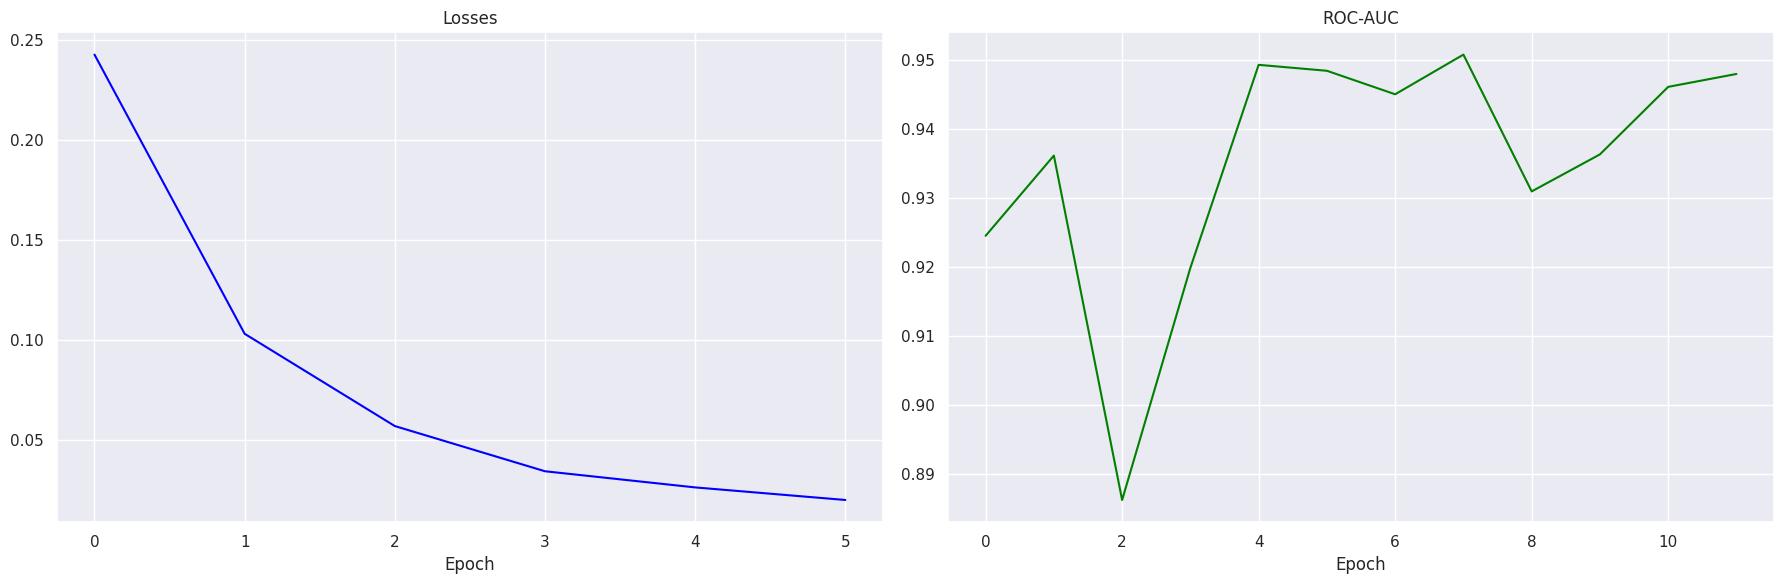

In [136]:
visualize(losses, roc_auc)

In [161]:
test_data = pd.read_csv('test_spam.csv')
test_data['text_type'] = 0
test_data

,text,text_type
0,j jim whitehead ejw cse ucsc edu writes j you ...,0
1,original message from bitbitch magnesium net p...,0
2,java for managers vince durasoft who just taug...,0
3,there is a youtuber name saiman says,0
4,underpriced issue with high return on equity t...,0
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,0
4066,baylor enron case study cindy yes i shall co a...,0
4067,boring as compared to tp,0
4068,hellogorgeous hows u my fone was on charge lst...,0


In [162]:
test_predict_dataset = Dataset.from_pandas(test_data)
test_predict_dataset = WordDataset(test_predict_dataset)
test_dataloader = DataLoader(
    test_predict_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=32)

In [164]:
predictions = []
texts = []
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        logits = model(batch['input_ids'])
        predictions.append(logits.argmax(dim=1))
        texts.append(batch['input_ids'])

predictions = torch.cat(predictions)

In [165]:
test_data['text_type'] = predictions.cpu()
test_data['text_type'] = test_data['text_type'].map({0 : 'ham', 1 : 'spam'})
test_data['text_type'].value_counts()

text_type
ham     2794
spam    1276
Name: count, dtype: int64

In [148]:
test_data.to_csv('predictions.csv', index=False)